In [1]:
from time import sleep
from datetime import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import pickle
import ast
import shap
import matplotlib.pyplot as plt
from joblib import dump, load
%matplotlib inline

In [2]:
df = pd.read_csv('../../NetML_nPrints_AMIR.csv')

In [3]:
df['feat_netml'] = df['feat_netml'].apply(lambda x: np.fromstring(x.replace("[", "").replace("]", "").replace("\n", " "), sep=' '))
df['device'] = df['device'].astype('category').cat.codes
df

,feat_sf,feat_netml,id,activity,user,device,duration,environment,pkt_0_rts,pkt_0_ipv4_ver_0,...,pkt_2_udp_cksum_6,pkt_2_udp_cksum_7,pkt_2_udp_cksum_8,pkt_2_udp_cksum_9,pkt_2_udp_cksum_10,pkt_2_udp_cksum_11,pkt_2_udp_cksum_12,pkt_2_udp_cksum_13,pkt_2_udp_cksum_14,pkt_2_udp_cksum_15
0,[-2.4095993 3.844843 1.5699135 0.602685...,"[40.1611521, 1.04578673, 78.0605096, 74.642857...",no_interaction_10_1614039254,check_on_fridge,2,2,23.0,lab,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,[-1.55087328e+00 1.81987643e+00 -2.96706796e-...,"[32.7930319, 0.518402813, 58.488035, 112.82352...",no_interaction_10_1625876191,check_on_fridge,2,2,20.0,lab,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,[-1.4870381e+00 2.3327003e+00 -3.9726704e-01 ...,"[37.8804579, 0.47517905, 39.1230751, 82.333333...",no_interaction_11_1625876247,check_on_fridge,2,2,28.0,lab,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,[-3.0589828e+00 3.6723382e+00 6.9139671e-01 ...,"[38.6043661, 4.0409937, 255.204294, 63.1538462...",no_interaction_1_1614038765,check_on_fridge,2,2,20.0,lab,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,[-1.54767513e+00 1.89816236e+00 -7.23878264e-...,"[31.1042991, 0.353648863, 22.2798784, 63.0, 21...",no_interaction_1_1625875733,check_on_fridge,2,2,17.0,lab,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2389,[-0.5366012 2.590208 1.3821554 -0.554435...,"[29.9272659, 0.534629527, 149.729682, 280.0625...",remote_control_8_1665931191,remote_control,7,3,11.0,home,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2390,[-4.68932897e-01 2.48179746e+00 1.45728672e+...,"[14.3336849, 0.767423036, 229.808316, 299.4545...",remote_control_8_1665933111,remote_control,7,3,14.0,home,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2391,[-2.76023775e-01 3.44942474e+00 9.02470350e-...,"[12.9773011, 0.847633872, 253.827816, 299.4545...",remote_control_9_1665875523,remote_control,7,3,13.0,home,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2392,[-0.7985164 2.4620621 1.6708086 -0.126684...,"[15.3377168, 0.717186276, 214.76469, 299.45454...",remote_control_9_1665931235,remote_control,7,3,11.0,home,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [4]:
from sklearn.model_selection import train_test_split

df = df.fillna(-1)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_X_train = df_train.iloc[:, 8:]
df_Y_train = df_train[['device', 'user']]
df_X_test = df_test.iloc[:, 8:]
df_Y_test = df_test[['device', 'user']]

In [12]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
neigh_pred = neigh.predict(df_X_test)
accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), neigh_pred)

0.7056367432150313

In [7]:
source_model = RandomForestClassifier(random_state=42)
source_model.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
# source_model_fi = source_model.feature_importances_

RandomForestClassifier(random_state=42)

In [8]:
threat_model = RandomForestClassifier(random_state=42)
threat_model.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())
# threat_model_fi = threat_model.feature_importances_

RandomForestClassifier(random_state=42)

In [9]:
threat_pred = threat_model.predict(df_X_test)
act_pred = source_model.predict(df_X_test)

threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier

base_ident = threat_score
base_acc = act_score

base_acc, base_ident

(0.9812108559498957, 0.8643006263048016)

In [14]:
base_acc, base_ident = (0.9812108559498957, 0.8643006263048016)


In [13]:
def compute_relative_effectiveness(ident, acc, base_ident, base_acc):
    numerator = ident - base_ident
    denominator = acc - base_acc
    if denominator == 0:
        return np.nan  # Avoid division by zero
    return np.log(numerator / denominator)

def plot_both_accuracies(score_list, legend_name):
    releff_list = [
        compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        for row in score_list
    ]
        
    plt.figure(figsize=(10, 6))

    plt.plot(score_list[:, 0], releff_list, 'ro', label=legend_name)
#     plt.scatter(1-score_list[:, 2], score_list[:, 1])

    plt.title(f'# features vs. Relative Effectiveness')
    plt.xlabel('Number of features')
    plt.ylabel('Relative Effectiveness')
    # plt.ylim(0, 1.1)
    # plt.xlim(0, 1.1)

    # Adding a legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig(f'{legend_name}.png')
    plt.show()

In [15]:
df_X_train.shape

(1915, 2667)

In [16]:
df_Y_train.shape

(1915, 2)

In [17]:
df_X_test.shape

(479, 2667)

In [18]:
df_Y_train

,device,user
1036,4,7
2205,3,7
1173,4,7
1402,0,7
507,2,7
...,...,...
1638,0,0
1095,4,7
1130,4,7
1294,4,0


In [19]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris
from scipy.stats import entropy
import numpy as np

# Compute mutual information for utility score
utility_scores = mutual_info_classif(df_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())
print("Utility Scores (Mutual Information):", utility_scores)

# Function to compute the entropy of a feature
def compute_feature_entropy(feature):
    p, _ = np.histogram(feature, bins=10, density=True)
    p = p[p > 0]  # Remove zero entries to avoid log(0) issues
    return entropy(p)

# Function to compute privacy scores
def compute_privacy_scores(X):
    privacy_scores = []
    original_entropies = [compute_feature_entropy(X[:, i]) for i in range(X.shape[1])]
    total_original_entropy = sum(original_entropies)

    for i in range(X.shape[1]):
        # Compute the entropy of the dataset without the i-th feature
        sanitized_entropies = original_entropies[:i] + original_entropies[i+1:]
        total_sanitized_entropy = sum(sanitized_entropies)
        # Privacy score is the decrease in entropy
        privacy_score = total_original_entropy - total_sanitized_entropy
        privacy_scores.append(privacy_score)
    return privacy_scores

# Compute privacy scores
privacy_scores = compute_privacy_scores(df_X_train.to_numpy())
print("Privacy Scores (Entropy-Based):", privacy_scores)


# Normalize scores for combining
utility_scores_normalized = np.array(utility_scores) / np.max(utility_scores)
privacy_scores_normalized = np.array(privacy_scores) / np.max(privacy_scores)

# Combine utility and privacy scores to compute trade-off scores
def trade_off_score(utility_scores, privacy_scores):
    return [(u + p) / 2 for u, p in zip(utility_scores_normalized, privacy_scores_normalized)]

# Compute trade-off scores
trade_off_scores = trade_off_score(utility_scores, privacy_scores)
print("Trade-Off Scores:", trade_off_scores)


Utility Scores (Mutual Information): [0.00789349 0.00567178 0.00971615 ... 0.00429553 0.         0.02960477]
Privacy Scores (Entropy-Based): [0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.05491316900634047, 0.2582813891551723, 0.3121482395320072, 0.05144618369922682, 0.16020062827533366, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.04324100151802668, 0.0582024389379967, 0.4104692119117317, 0.39894854074168506, 0.5398403135338867, 0.7306667349250802, 0.7233220307424517, 0.7237163630313717, 0.7311525279912985, 0.6955849624707753, 0.5871173485695635, 0.7141063793715148, 0.6613980726483533, 0.7294394559684179, 0.6961534792751536, 0.7313041684693644, 0.7284302606775555, 0.7286647368794092, 0.7311887912497923, 0.7308096316994579, 0.729688072770954

In [20]:
dump(utility_scores, '../iot_nprint_3pkts_utility_scores.joblib')
dump(privacy_scores, '../iot_nprint_3pkts_privacy_scores.joblib')
dump(trade_off_scores, '../iot_nprint_3pkts_trade_off_scores.joblib')

['../iot_nprint_3pkts_trade_off_scores.joblib']

In [76]:
np.argsort(utility_scores)[-14:]

array([1495, 2384, 2252,  574, 2254, 1381,  476, 1365,  474,  473, 1362,
       1363, 1778,  889])

In [21]:
# Function to remove features with the lowest n scores
def remove_lowest_features(X, scores, n):
    # Get the indices of the features sorted by score
    sorted_indices = np.argsort(scores)
    # Get the indices of the features to remove
    indices_to_remove = sorted_indices[:n]
    # Remove the features from X
    X_modified = np.delete(X, indices_to_remove, axis=1)
    return X_modified


100%|█████████████████████████████████████████████████████████████████████████████| 2666/2666 [1:22:47<00:00,  1.86s/it]
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


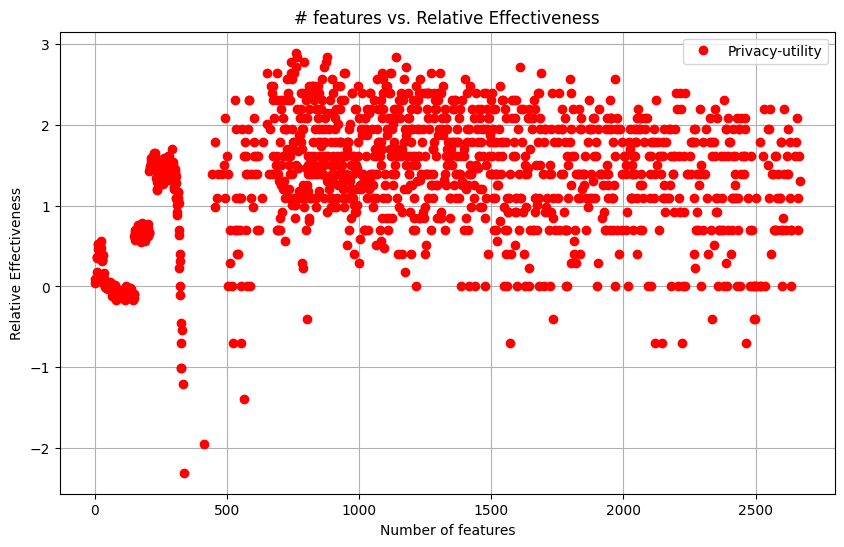

In [22]:
# Privacy-utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(trade_off_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), trade_off_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), trade_off_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-privacy-utility.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy-utility')

100%|█████████████████████████████████████████████████████████████████████████████| 2666/2666 [1:19:24<00:00,  1.79s/it]
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


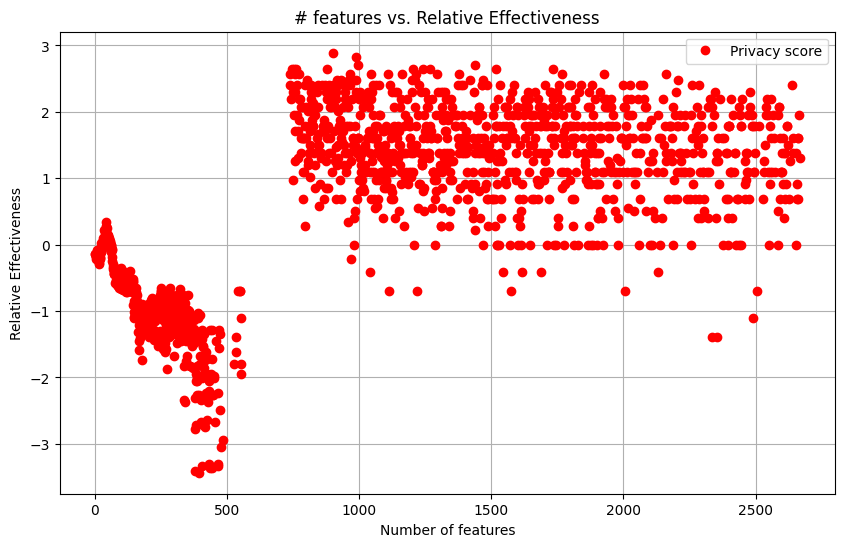

In [23]:
# Privacy score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(privacy_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), privacy_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), privacy_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-privacy-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy score')

100%|█████████████████████████████████████████████████████████████████████████████| 2666/2666 [1:18:11<00:00,  1.76s/it]
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


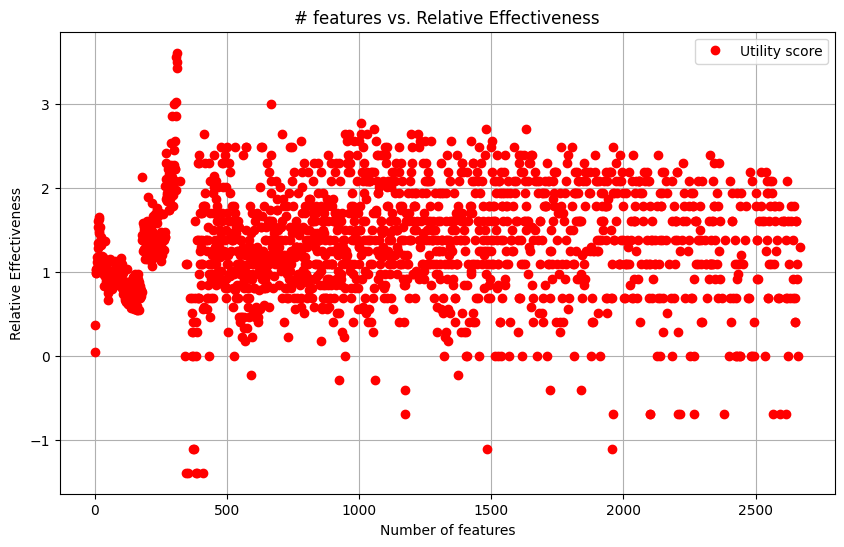

In [24]:
# Feature utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(utility_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), utility_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), utility_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-utility-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Utility score')

In [25]:
from sklearn.feature_extraction import FeatureHasher

def feature_hashing(df, n_features):
    # Convert DataFrame to a list of dictionaries
    data_dict = df.to_dict(orient='records')

    # Initialize FeatureHasher
    hasher = FeatureHasher(n_features=n_features, input_type='dict')

    # Transform data
    hashed_features = hasher.transform(data_dict).toarray()

    # Convert hashed features to DataFrame if needed
    hashed_df = pd.DataFrame(hashed_features)
    return hashed_df

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def pca_reduction(df, n_components):
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    
    # Initialize PCA
    pca = PCA(n_components=n_components)
    
    # Fit and transform the data
    pca_features = pca.fit_transform(scaled_features)
    
    # Convert PCA features to DataFrame
    pca_df = pd.DataFrame(pca_features)
    return pca_df


In [27]:
def plot_multiple_accuracies(score_lists, legend_names):
    plt.figure(figsize=(10, 6))
    
    # Define a list of colors for different plots
    colors = ['ro-', 'bo-', 'go-', 'co-', 'mo-', 'yo-', 'r--', 'b--', 'g--']
    marker_size = 2

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        plt.plot(1 - score_list[:, 2], score_list[:, 1], color, label=legend_name, markersize=marker_size)
    
    plt.title('Comparison of Threat vs. Source Models Accuracy')
    plt.xlabel('1-threat accuracy')
    plt.ylabel('Source model accuracy')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
             bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center')

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('comparison_plot.png')
    plt.show()


100%|█████████████████████████████████████████████████████████████████████████████████| 178/178 [18:52<00:00,  6.36s/it]
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


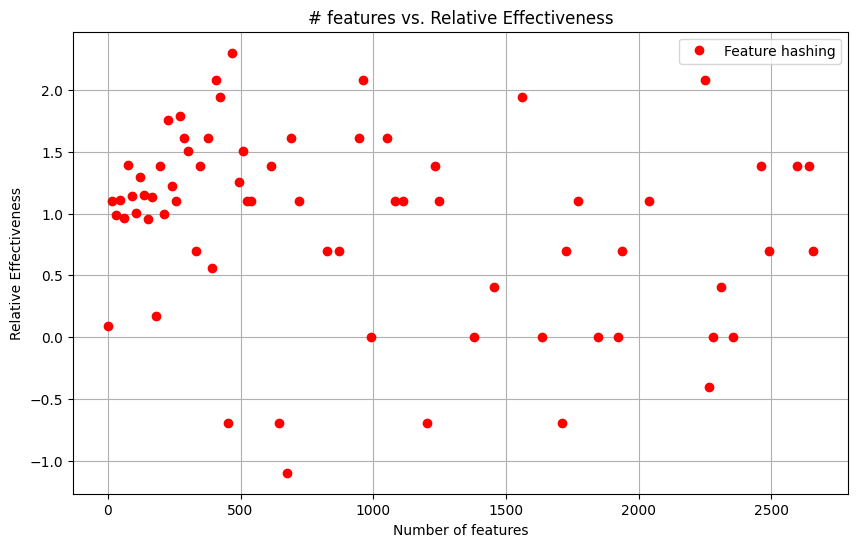

In [28]:
# Feature hashing
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(1, df_X_train.shape[1], 15)):
        hashed_X_train = feature_hashing(df_X_train, n_features)
        hashed_X_test = feature_hashing(df_X_test, n_features)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(hashed_X_test)
        act_pred = rfc_act.predict(hashed_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([n_features, act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-feature_hashing.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Feature hashing')

In [ ]:
# PCA dimensionality reduction
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,51)):
        reduced_X_train = pca_reduction(df_X_train, n_features)
        reduced_X_test = pca_reduction(df_X_test, n_features)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(reduced_X_test)
        act_pred = rfc_act.predict(reduced_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([reduced_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-pca_reduction.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'PCA')

 73%|████████████████████████████████████████████████████████████▌                      | 35/48 [02:20<01:19,  6.15s/it]

In [ ]:
from sklearn.decomposition import SparsePCA

# SparsePCA dimensionality reduction
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,51)):
        transformer = SparsePCA(n_components=n_features, random_state=42)
        transformer.fit(df_X_train)
        reduced_X_train = transformer.transform(df_X_train)
        reduced_X_test = transformer.transform(df_X_test)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(reduced_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(reduced_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(reduced_X_test)
        act_pred = rfc_act.predict(reduced_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1], threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0], act_pred) # Network Intrusion classifier
        score_list.append([reduced_X_train.shape[1], act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-sparse_pca.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'SparsePCA')

In [ ]:
def add_laplace_noise(df, epsilon):
    # Define the scale of the Laplace noise
    scale = 1.0 / epsilon
    
    # Create a noise matrix with the same shape as the DataFrame
    noise = np.random.laplace(loc=0, scale=scale, size=df.shape)
    
    # Add the noise to the original DataFrame
    noisy_df = df + noise
    
    # Convert the result back to a DataFrame
    noisy_df = pd.DataFrame(noisy_df, columns=df.columns)
    return noisy_df

In [ ]:
# Differential privacy: laplace noise
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for epsilon in tqdm([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]):
        noisy_X_train = add_laplace_noise(df_X_train, epsilon)
        noisy_X_test = add_laplace_noise(df_X_test, epsilon)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(noisy_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(noisy_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(noisy_X_test)
        act_pred = rfc_act.predict(noisy_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([epsilon, act_score, threat_score])

np.savetxt(f'iot_nprint_3pkts-differential_privacy.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Differential privacy')

In [39]:
from sklearn.metrics import accuracy_score
from joblib import dump, load
def get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi / (1+source_model_fi)
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi / (1+source_model_fi) >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx]
    new_test = df_X_test.iloc[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = source_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(source_model_fi >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx]
    new_test = df_X_test.iloc[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

def get_accuracy_for_threat_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi <= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx]
    new_test = df_X_test.iloc[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

source_model = RandomForestClassifier(random_state=42)
source_model.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
source_model_fi = rfc_act.feature_importances_

threat_model = RandomForestClassifier(random_state=42)
threat_model.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())
threat_model_fi = rfc_threat.feature_importances_

# dump(source_model_fi, 'serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# dump(threat_model_fi, 'serv_rec_full_nprint_10pkts_threat_model_fi.joblib')
# source_model_fi = load('serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# threat_model_fi = load('serv_rec_full_nprint_10pkts_threat_model_fi.joblib')

score_list_both = []
for perc in [0.03,0.1,0.3,1,3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_both.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_both_random_forest_iot_nprint_3pkts.csv', np.array(score_list_both), delimiter=",")

score_list_source = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_source_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_source.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_source_random_forest_iot_nprint_3pkts.csv', np.array(score_list_source), delimiter=",")

score_list_threat = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_threat_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_threat.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_threat_random_forest_iot_nprint_3pkts.csv', np.array(score_list_threat), delimiter=",")

Both score: [0.00045302 0.00021784 0.00063049 ... 0.00038806 0.00040002 0.00030558]
Features for both: [450]
Percentile of features to keep: 0.03; Number of features to keep: 1; Ratio Threshold: 0.0043639939277611796
Both score: [0.00045302 0.00021784 0.00063049 ... 0.00038806 0.00040002 0.00030558]
Features for both: [ 450  889 2224]
Percentile of features to keep: 0.1; Number of features to keep: 3; Ratio Threshold: 0.0038120656157935315
Both score: [0.00045302 0.00021784 0.00063049 ... 0.00038806 0.00040002 0.00030558]
Features for both: [  32  450  889 1299 1497 2224 2228 2276]
Percentile of features to keep: 0.3; Number of features to keep: 8; Ratio Threshold: 0.0034707052900604905
Both score: [0.00045302 0.00021784 0.00063049 ... 0.00038806 0.00040002 0.00030558]
Features for both: [  29   32  443  450  492  499  889  922  968 1299 1307 1308 1387 1497
 1499 1778 2190 2197 2222 2224 2228 2269 2276 2277 2354 2356 2380]
Percentile of features to keep: 1; Number of features to keep: 

In [38]:
from sklearn.metrics import accuracy_score
from joblib import dump, load
def get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi / (1+source_model_fi)
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi / (1+source_model_fi) >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx]
    new_test = df_X_test.iloc[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = source_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(source_model_fi >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx]
    new_test = df_X_test.iloc[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

def get_accuracy_for_threat_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi <= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx]
    new_test = df_X_test.iloc[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score


In [48]:
def plot_multiple_accuracy_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 1], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Prediction Accuracy After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-accuracy-features.pdf')
    plt.show()


def plot_multiple_ident_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 2], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Identifiability vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Identifiability After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-ident-features.pdf')
    plt.show()


In [49]:
def plot_multiple_releff_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-releff-comparison.pdf')
    plt.show()


In [50]:
def plot_multiple_releff_accuracies(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 1], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Accuracy')
    plt.xlabel('Prediction Accuracy After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-releff-accuracy.pdf')
    plt.show()

def plot_multiple_releff_ident(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 2], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Identifiability')
    plt.xlabel('Identifiability After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('iot_nprint_3pkts-releff-identifiability.pdf')
    plt.show()


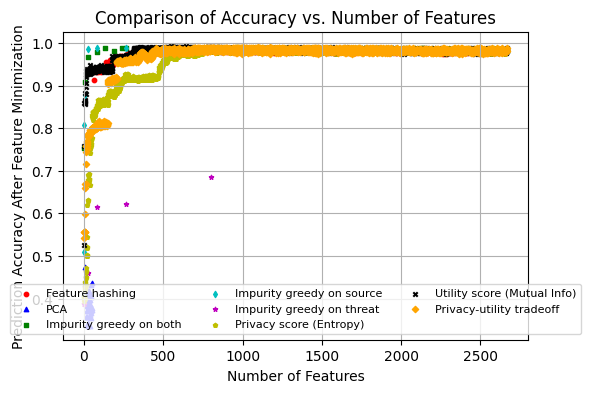

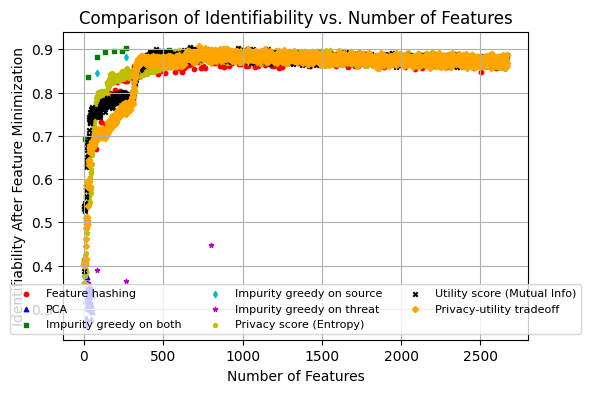

/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


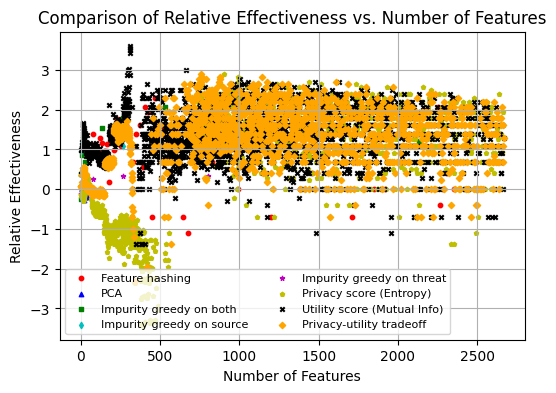

/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


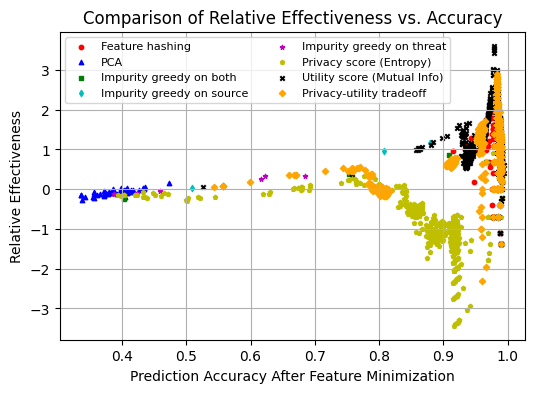

/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_3109280/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


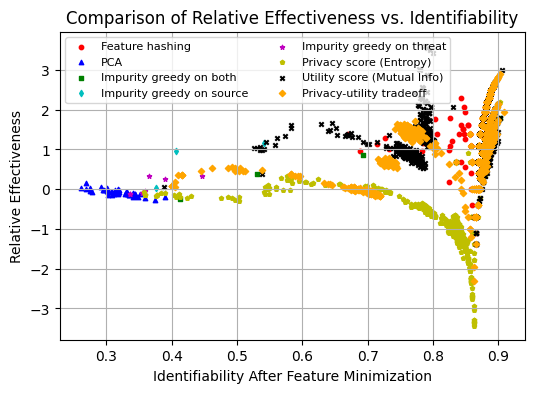

In [51]:
score_list_fh = np.loadtxt(f'iot_nprint_3pkts-feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'iot_nprint_3pkts-pca_reduction.csv', delimiter=",")
# score_list_dp = np.loadtxt(f'iot_nprint_3pkts-differential_privacy-features.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'iot_nprint_3pkts-privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'iot_nprint_3pkts-utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'iot_nprint_3pkts-privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'./impurity.score_list_both_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_source = np.loadtxt(f'./impurity.score_list_source_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_threat = np.loadtxt(f'./impurity.score_list_threat_random_forest_iot_nprint_3pkts.csv', delimiter=",")

score_lists = [score_list_fh[4:, :], score_list_pca[4:, :],# score_list_dp,
               score_list_both, score_list_source, score_list_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility]
legend_lists = ['Feature hashing', 'PCA', #'Differential privacy',
                'Impurity greedy on both', 'Impurity greedy on source', 'Impurity greedy on threat',
                'Privacy score (Entropy)', 'Utility score (Mutual Info)', 'Privacy-utility tradeoff']
plot_multiple_accuracy_features(score_lists, legend_lists)
plot_multiple_ident_features(score_lists, legend_lists)
plot_multiple_releff_features(score_lists, legend_lists)
plot_multiple_releff_accuracies(score_lists, legend_lists)
plot_multiple_releff_ident(score_lists, legend_lists)

In [58]:
def plot_absolute_accuracy(score_list, base_accuracy, base_ident, method=''):
    # Extract values
    num_features = score_list[:, 0]
    accuracy = base_accuracy - score_list[:, 1]
    ident_diff = base_ident - score_list[:, 2]
    # y_max = max(max(accuracy), max(ident_diff))
    y_max = 0.7

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Left y-axis for accuracy
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Accuracy Loss', color='tab:blue')
    ax1.plot(num_features, accuracy, 'o-', color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, y_max)

    # Right y-axis for identification difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Identifiability Reduction', color='tab:red')
    ax2.plot(num_features, ident_diff, 's-', color='tab:red', label='Identifiability Reduction')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, y_max)

    # Title and grid
    plt.title(f'# Features vs. Accuracy Loss & Identifiability Reduction ({method})', fontsize=8)
    fig.tight_layout()
    plt.grid(True)

    # Save and show
    plt.savefig(f'iot_nprint_3pkts-aligned-nprint-{method}.pdf')
    plt.show()



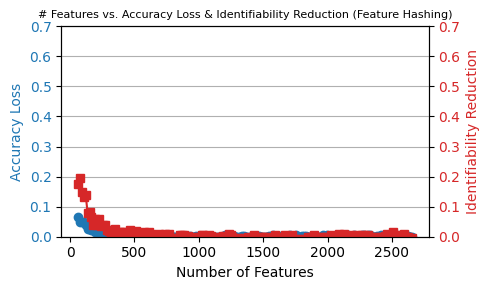

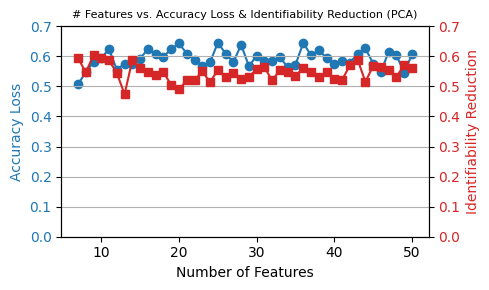

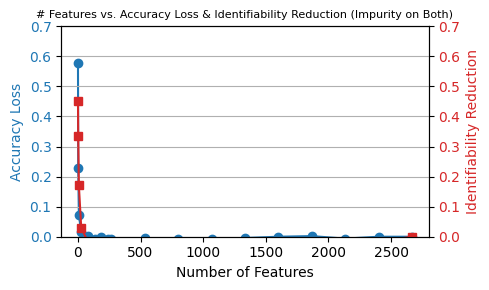

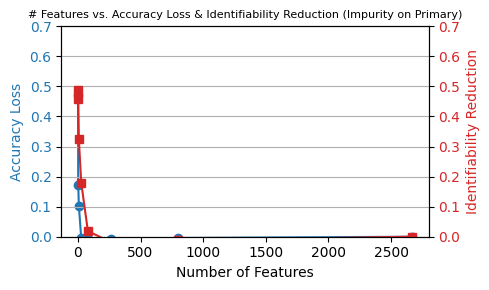

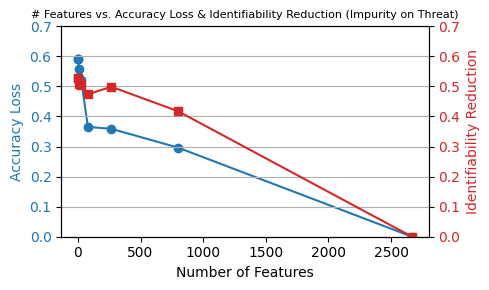

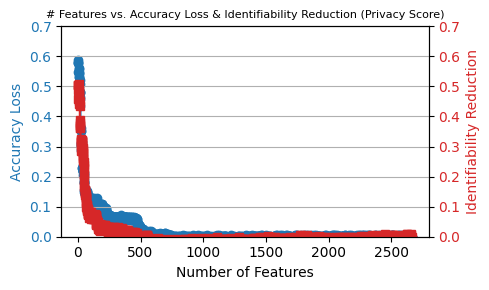

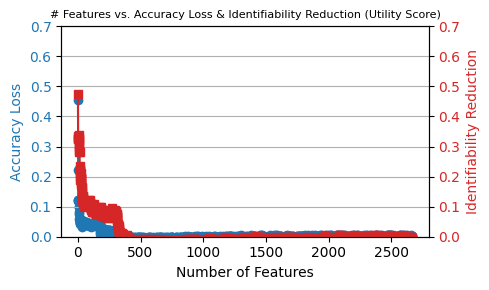

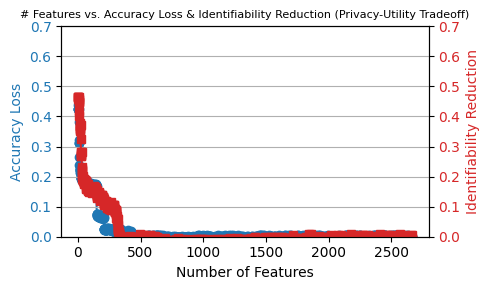

[None, None, None, None, None, None, None, None]

In [59]:
score_list_fh = np.loadtxt(f'iot_nprint_3pkts-feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'iot_nprint_3pkts-pca_reduction.csv', delimiter=",")
# score_list_dp = np.loadtxt(f'iot_nprint_3pkts-differential_privacy-features.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'iot_nprint_3pkts-privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'iot_nprint_3pkts-utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'iot_nprint_3pkts-privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_impurity_both = np.loadtxt(f'./impurity.score_list_both_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'./impurity.score_list_source_random_forest_iot_nprint_3pkts.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'./impurity.score_list_threat_random_forest_iot_nprint_3pkts.csv', delimiter=",")

# score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
# score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
# score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_lists = [score_list_fh[4:, :], score_list_pca[4:, :], #score_list_dp,
               score_list_impurity_both, score_list_impurity_source, score_list_impurity_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility,]
               #score_list_both, score_list_source, score_list_threat,]

methods = ['Feature Hashing', 'PCA', 'Impurity on Both', 'Impurity on Primary', 'Impurity on Threat',
           'Privacy Score', 'Utility Score', 'Privacy-Utility Tradeoff'] #, 'SHAP on Both', 'SHAP on Primary', 'SHAP on Both']
[plot_absolute_accuracy(score_list, base_acc, base_ident, method) for score_list, method in zip(score_lists, methods)]
